<a href="https://colab.research.google.com/github/sepandms/SkinCare/blob/main/CNN_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
G_path = '/content/drive/MyDrive/DataSources/SkinCare/'
G_Aug = '/content/drive/MyDrive/DataSources/SkinCare/Augmented_AutoEncoded/'
G_save = G_path + 'Saved/'
!pip install pickle5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset as dset
#import torchvision.transforms.Compose
import numpy as np
from datetime import datetime	
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
import pickle as pickle
from statistics import mean
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
path = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Data/Pickle_Data/'
p_models = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Models/Saved/'

In [3]:
#file = 'test1.pkl' 
file = 'AutoEncoder_input_data_blc' 
try:
    infile = open(G_Aug + file,'rb') # for google colab
except:
    infile = open(path+file,'rb') # for M1
input_data = pickle.load(infile)

file = 'AutoEncoder_labels_blc' 
try:
    infile = open(G_Aug + file,'rb') # for google colab
except:
    infile = open(path+file,'rb') # for M1
labels = pickle.load(infile)

# **Standardize Train and Validation data**

In [4]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32, stride = 2 , kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d( kernel_size = (3,3), stride = 2, padding = 0 )
        self.conv2 = nn.Conv2d( in_channels=32, out_channels=64, stride = 2 , kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d( kernel_size = (3,3), stride = 2, padding = 0 )
        self.fc1   = nn.Linear(in_features= 12288 , out_features = 256)
        self.fc2   = nn.Linear(in_features= 256, out_features = 7)
        self.Act   = nn.LeakyReLU(inplace=True)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        out = self.Act(self.conv1(x))
        out = self.Act(self.pool1(out))
        out = self.dropout(out)
        out = self.Act(self.conv2(out))
        out = self.Act(self.pool2(out))
        out = self.dropout(out)
        out = torch.flatten(out, 1) 
        out = self.Act(self.fc1(out))
        out = self.fc2(out)
        return out
    def forward_noDrop(self, x):
        out = self.Act(self.conv1(x))
        out = self.Act(self.pool1(out))
        out = self.Act(self.conv2(out))
        out = self.Act(self.pool2(out))
        out = torch.flatten(out, 1) 
        out = self.Act(self.fc1(out))
        out = self.fc2(out)
        return out

class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32, stride = 2 , kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d( kernel_size = (3,3), stride = 2, padding = 0 )
        self.conv2 = nn.Conv2d( in_channels=32, out_channels=64, stride = 2 , kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d( kernel_size = (3,3), stride = 2, padding = 0 )
        self.fc1   = nn.Linear(in_features= 12288 , out_features = 256)
        self.fc2   = nn.Linear(in_features= 256, out_features = 7)
        self.Act   = nn.LeakyReLU(inplace=True)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        out = self.Act(self.conv1(x))
        out = self.Act(self.pool1(out))
        out = self.dropout(out)
        out = self.Act(self.conv2(out))
        out = self.Act(self.pool2(out))
        out = self.dropout(out)
        out = torch.flatten(out, 1) 
        out = self.Act(self.fc1(out))
        out = self.fc2(out)
        return out
    def forward_noDrop(self, x):
        out = self.Act(self.conv1(x))
        out = self.Act(self.pool1(out))
        out = self.Act(self.conv2(out))
        out = self.Act(self.pool2(out))
        out = torch.flatten(out, 1) 
        out = self.Act(self.fc1(out))
        out = self.fc2(out)
        return out

In [5]:
class CNN_Nets:

  class Net1(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32 , kernel_size=(3, 3))
          self.conv2 = nn.Conv2d( in_channels=32, out_channels=32 , kernel_size=(3, 3))
          self.pool1 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
          self.conv3 = nn.Conv2d( in_channels=32, out_channels=64 , kernel_size=(3, 3))
          self.conv4 = nn.Conv2d( in_channels=64, out_channels=64 , kernel_size=(3, 3))
          self.pool2 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
          self.fc1   = nn.Linear(in_features= 6144 , out_features = 512)
          self.fc2   = nn.Linear(in_features= 512, out_features = 7)
          self.Act   = nn.ReLU(inplace=True)
      def forward(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.conv2(out))
          out = self.Act(self.pool1(out))
          out = self.Act(self.conv3(out))
          out = self.Act(self.conv4(out))
          out = self.Act(self.pool2(out))
          out = torch.flatten(out, 1) 
          out = self.Act(self.fc1(out))
          out = self.Act(self.fc2(out))
          # out = nn.Softmax(out)
          return out

  class Net2(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32 , kernel_size=(3, 3))
          self.pool1 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
          self.conv3 = nn.Conv2d( in_channels=32, out_channels=64 , kernel_size=(3, 3))
          self.pool2 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
          self.fc1   = nn.Linear(in_features= 7488 , out_features = 512)
          self.fc2   = nn.Linear(in_features= 512, out_features = 7)
          self.Act   = nn.ReLU(inplace=True)
      def forward(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.pool1(out))
          out = self.Act(self.conv3(out))
          out = self.Act(self.pool2(out))
          out = torch.flatten(out, 1) 
          out = self.Act(self.fc1(out))
          out = self.Act(self.fc2(out))
          return out

  class Net3(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d( in_channels=3 , out_channels=24 , kernel_size=(3, 3))
          self.pool1 = nn.MaxPool2d( kernel_size = (3,3), stride = None, padding = 0 )
          self.conv2 = nn.Conv2d( in_channels=24, out_channels=12 , kernel_size=(3, 3))
          self.pool2 = nn.MaxPool2d( kernel_size = (3,3), stride = None, padding = 0 )
          self.fc1   = nn.Linear(in_features= 7920 , out_features = 256)
          self.fc2   = nn.Linear(in_features= 256, out_features = 7)
          self.Act   = nn.LeakyReLU(inplace=True)
          self.dropout = nn.Dropout(0.4)
      def forward(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.pool1(out))
          out = self.dropout(out)
          out = self.Act(self.conv2(out))
          out = self.Act(self.pool2(out))
          out = self.dropout(out)
          out = torch.flatten(out, 1) 
          out = self.Act(self.fc1(out))
          out = self.fc2(out)
          return out
      def forward_noDrop(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.pool1(out))
          out = self.Act(self.conv2(out))
          out = self.Act(self.pool2(out))
          out = torch.flatten(out, 1) 
          out = self.Act(self.fc1(out))
          out = self.fc2(out)
          return out

  class Net4(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d( in_channels=3 , out_channels=16 , kernel_size=(3, 3))
          self.pool1 = nn.MaxPool2d( kernel_size = (3,3), stride = 1, padding = 0 )
          self.conv2 = nn.Conv2d( in_channels=16, out_channels=24 , kernel_size=(3, 3))
          self.pool2 = nn.MaxPool2d( kernel_size = (3,3), stride = 1, padding = 0 )
          self.fc1   = nn.Linear(in_features= 1320000 , out_features = 256)
          self.fc2   = nn.Linear(in_features= 256, out_features = 7)
          self.Act   = nn.LeakyReLU(inplace=True)
          self.dropout = nn.Dropout(0.3)
      def forward(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.pool1(out))
          out = self.dropout(out)
          out = self.Act(self.conv2(out))
          out = self.Act(self.pool2(out))
          out = self.dropout(out)
          out = torch.flatten(out, 1) 
          out = self.Act(self.fc1(out))
          out = self.fc2(out)
          return out

  class Net5(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d( in_channels=3 , out_channels=16 , kernel_size=(3, 3))
          self.pool1 = nn.MaxPool2d( kernel_size = (3,3), stride = 1, padding = 0 )
          self.fc1   = nn.Linear(in_features= 55104 , out_features = 7)
          self.Act   = nn.LeakyReLU(inplace=True)
          self.dropout = nn.Dropout(0.3)
      def forward(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.pool1(out))
          out = self.dropout(out)
          out = torch.flatten(out, 1) 
          out = self.fc1(out)
          return out

  class Net6(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d( in_channels=3 , out_channels=16 , kernel_size=(3, 3))
          self.pool1 = nn.MaxPool2d( kernel_size = (4,4), stride = None, padding = 0 )
          self.fc1   = nn.Linear(in_features= 57120 , out_features = 256)
          self.fc2   = nn.Linear(in_features= 256 , out_features = 7)
          self.Act   = nn.LeakyReLU(inplace=True)
          self.dropout = nn.Dropout(0.3)
      def forward(self, x):
          out = self.Act(self.conv1(x))
          out = self.Act(self.pool1(out))
          out = self.dropout(out)
          out = torch.flatten(out, 1) 
          out = self.Act(self.fc1(out))
          out = self.fc2(out)
          return out

# **Test Nets**

In [7]:
model_test = Net3()
X_ = input_data[0][0:5]
out = model_test(X_)
out.shape

torch.Size([5, 7])

# **Confusion-Matrix & Accuracy**

In [5]:
def confusion_matrix(Y,Y_pred):
    CM = sk.metrics.confusion_matrix(Y,Y_pred)
    print('Nr. of Data : \n', CM.sum())
    print('Accuracy of The Model : \n', np.diag(CM).sum()/CM.sum())
    # print('Confusion Matrix : \n', CM)
    # print('Weighted Avg. of sensitivity : \n', np.average(np.nan_to_num(sensitivity), weights=weights))
    # print('Weighted Avg. of specificity : \n', np.average(np.nan_to_num(specificity), weights=weights))
    sk.metrics.ConfusionMatrixDisplay(CM).plot()
    # print('------- Precision recal %--------')
    # print(sk.metrics.classification_report(Y,Y_pred))
    # print('------- confusion matrix--------')

    FP = CM.sum(axis=0) - np.diag(CM) 
    FN = CM.sum(axis=1) - np.diag(CM)
    TP = np.diag(CM)
    TN = CM.sum() - (FP + FN + TP)
    weights = CM.sum(axis=1) / CM.sum() 
    ACC = np.nan_to_num((TP+TN)/(TP+FP+FN+TN) , nan=0)
    Recall_Sensitivity = np.nan_to_num(TP/(TP+FN) , nan=0)
    Specificity = np.nan_to_num(TN/(TN+FP) , nan=0)
    Precision = np.nan_to_num(TP/(TP+FP) , nan=0)
    f1_score = np.nan_to_num( 2*Precision*Recall_Sensitivity / (Recall_Sensitivity + Precision), nan=0)
    Performance_DF = pd.concat([pd.DataFrame(CM),pd.DataFrame(weights, columns=['weights']),pd.DataFrame(Precision, columns=['Precision']),pd.DataFrame(Recall_Sensitivity,columns=['Recall_Sensitivity'])
        ,pd.DataFrame(Specificity, columns=['Specificity']),pd.DataFrame(f1_score, columns=['f1_score'])], axis=1)
    total_row1 = pd.Series({'Precision':mean(Precision),'Recall_Sensitivity':mean(Recall_Sensitivity),'Specificity':mean(Specificity),'f1_score':mean(f1_score)}, name='Simple Avg.')
    total_row2 = pd.Series({'Precision':sum(weights*Precision),'Recall_Sensitivity':sum(weights*Recall_Sensitivity),'Specificity':sum(weights*Specificity),'f1_score':sum(weights*f1_score)}, name='Weighted Avg.')
    Performance_DF = Performance_DF.append([total_row1,total_row2])
    cols = ['weights','Precision','Recall_Sensitivity','Specificity','f1_score']
    per_details = Performance_DF[cols].style.format({'weights': "{:.1%}",'Precision': "{:.1%}",'Recall_Sensitivity': "{:.1%}",'Specificity': "{:.1%}",'f1_score': "{:.1%}"})
    return per_details

### **1.3 Training**

In [6]:
class Model_Training:

    def __init__(self, Net, LR, batch_size , Momentum, epochs, weight_decay, loss_func, opt_func, X_train, Y_train, X_valid, Y_valid,X_test,Y_test, print_epochs,hyper_params,Test_acc_print):    
        
        self.model = Net().to(device)
        if opt_func is torch.optim.Adam:
            self.opt = opt_func(self.model.parameters(), lr=LR, weight_decay=weight_decay)
        else:
            self.opt = opt_func(self.model.parameters(), lr=LR,momentum=Momentum, weight_decay=weight_decay)

        self.loss_func = loss_func()
        self.epochs = epochs
        self.print_epochs = print_epochs
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_valid = X_valid
        self.Y_valid = Y_valid
        self.X_test = X_test
        self.Y_test = Y_test
        self.batch_size = batch_size
        self.Epochs_Train_loss = []
        self.Epochs_Train_Acc = []
        self.Epochs_Val_loss = []
        self.Epochs_Val_Acc = []
        self.hyper_params = hyper_params
        self.Test_acc_print = Test_acc_print

    def train(self):
        
        model = self.model
        loss_fn = self.loss_func
        opt = self.opt 
        batch_size = self.batch_size
        nr_of_steps_train =  self.X_train.shape[0]//self.batch_size 
        nr_of_steps_valid =  self.X_valid.shape[0]//self.batch_size 

        for epoch in range(1, self.epochs+1 ):
            start_time=time.time()
            steps_train_loss = []
            steps_train_Acc = []
            steps_val_loss = []
            steps_val_Acc = []

            for i in range(0, nr_of_steps_train ):#train_arrays_std.shape[0]):
                X = self.X_train[i* batch_size:(i+1) * batch_size]
                X = X.to(device)
                Y = self.Y_train[i * batch_size:(i+1) * batch_size]
                Y = Y.to(device)

                opt.zero_grad()
                model.train()
                y_pred = model.forward(X)
                loss = loss_fn(y_pred, Y)
                loss.backward()
                opt.step()
                y_pred_labels = y_pred.argmax(axis=1)
                nr_of_corrects = (y_pred_labels == Y).sum().item()
                step_acc = nr_of_corrects / batch_size
                steps_train_Acc.append(step_acc)
                steps_train_loss.append(loss.item())

                # if (i+1) % 200 == 0:    # print every 2000 mini-batches
                #     print('[Epoch: {}, Nr. Batch: {}]  , Train-Steps-loss: {:.1f} , running_acc: {:.1%}'.format(epoch , i+1 , train_steps_loss , batch_nr_correct / train_nr_total))
                #     self.train_steps_acc = []
                #     train_steps_loss = 0

              #validation loss calculation
            for j in range(0,nr_of_steps_valid):

                val_X = self.X_valid[j*batch_size:(j+1)*batch_size]
                val_X = val_X.to(device)
                val_Y = self.Y_valid[j*batch_size:(j+1)*batch_size]
                val_Y = val_Y.to(device)
                model.eval()
                # val_inputs = val_inputs.to(device)
                # val_labels = val_labels.to(device)
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_Y)
                val_epoch_loss = val_loss.item()
                val_outputs_lbs= val_outputs.argmax(axis=1)
                val_nr_correct = (val_outputs_lbs == val_Y).sum().item()
                step_acc = val_nr_correct / batch_size
                steps_val_Acc.append(step_acc)
                steps_val_loss.append(val_epoch_loss)
            #Test Set Performance
            if self.Test_acc_print:
                X_test = self.X_test.to(device)
                Y_test = self.Y_test.to(device)
                Y_pred = model(X_test).argmax(dim=1)
                test_acc = sk.metrics.accuracy_score(Y_test.to('cpu'),Y_pred.to('cpu') )
            else:
                test_acc = '_'
            # Epoch Performance Metrics
            train_epoch_loss = mean(steps_train_loss)
            train_epoch_Acc = mean(steps_train_Acc)
            self.Epochs_Train_loss.append(train_epoch_loss)
            self.Epochs_Train_Acc.append(train_epoch_Acc)   
            val_epoch_loss = mean(steps_val_loss)
            val_epoch_Acc = mean(steps_val_Acc)
            self.Epochs_Val_loss.append(val_epoch_loss)
            self.Epochs_Val_Acc.append(val_epoch_Acc)
            End_time = time.time() 
            if self.print_epochs:
                print('[Epoch: {}]  , Train_loss: {:.1f} , Train_Acc: {:.1%}, Val_loss: {:.1f} , Val_Acc: {:.1%}, Test_Acc: {:.1%}  , run time: {}'.format(epoch , train_epoch_loss , train_epoch_Acc , val_epoch_loss , val_epoch_Acc,test_acc, np.round(End_time - start_time, 2)))
            
        # print('Finished Training')

In [7]:
class Model_Training_with_loader:

    def __init__(self, Net, LR, batch_size , Momentum, epochs, weight_decay, loss_func, opt_func,w_sampler, trainDataset, validDataset, X_test,Y_test, print_epochs,hyper_params):    
        
        self.model = Net().to(device)
        if opt_func is torch.optim.Adam:
            self.opt = opt_func(self.model.parameters(), lr=LR, weight_decay=weight_decay)
        else:
            self.opt = opt_func(self.model.parameters(), lr=LR,momentum=Momentum, weight_decay=weight_decay)

        self.loss_func = loss_func()
        self.epochs = epochs
        self.print_epochs = print_epochs
        self.batch_size = batch_size
        self.Epochs_Train_loss = []
        self.Epochs_Train_Acc = []
        self.Epochs_Val_loss = []
        self.Epochs_Val_Acc = []
        self.Epochs_test_loss = []
        self.Epochs_test_Acc = []
        self.hyper_params = hyper_params
        self.Y_test = Y_test
        self.X_test = X_test
        self.train_loader = DataLoader(dataset = trainDataset , sampler = w_sampler, batch_size = self.batch_size, num_workers=4)
        self.valid_loader = DataLoader(dataset = validDataset , shuffle=True, batch_size = self.batch_size, num_workers=2)
        self.test_loader = DataLoader(dataset = testDataset , shuffle=True, batch_size = self.batch_size, num_workers=2)

    def train(self):
        
        model = self.model
        loss_fn = self.loss_func
        opt = self.opt 
        batch_size = self.batch_size

        for epoch in range(1, self.epochs+1 ):
            start_time=time.time()
            steps_train_loss = []
            steps_train_Acc = []
            steps_val_loss = []
            steps_val_Acc = []
            steps_test_loss = []
            steps_test_Acc = []
            torch.cuda.empty_cache()
            for batch, (X, Y) in enumerate(self.train_loader):
                X = X.to(device)
                Y = Y.to(device)
                opt.zero_grad()
                model.train()
                y_pred = model.forward(X)
                loss = loss_fn(y_pred, Y)
                loss.backward()
                opt.step()
                y_pred = y_pred.argmax(axis=1)
                nr_of_corrects = (y_pred == Y).sum().item()
                step_acc = nr_of_corrects / batch_size
                steps_train_Acc.append(step_acc)
                steps_train_loss.append(loss.item())

                # if (i+1) % 200 == 0:    # print every 2000 mini-batches
                #     print('[Epoch: {}, Nr. Batch: {}]  , Train-Steps-loss: {:.1f} , running_acc: {:.1%}'.format(epoch , i+1 , train_steps_loss , batch_nr_correct / train_nr_total))
                #     self.train_steps_acc = []
                #     train_steps_loss = 0

              #validation loss calculation
            for batch, (X, Y) in enumerate(self.valid_loader):
                X = X.to(device)
                Y = Y.to(device)
                model.eval()
                Y_pred = model(X)
                loss_ = loss_fn(Y_pred, Y)
                epoch_loss = loss_.item()
                Y_pred = Y_pred.argmax(axis=1)
                nr_correct = (Y_pred == Y).sum().item()
                step_acc = nr_correct / batch_size
                steps_val_Acc.append(step_acc)
                steps_val_loss.append(epoch_loss)
              
            #Test Set Performance
            for batch, (X, Y) in enumerate(self.test_loader):
                X = X.to(device)
                Y = Y.to(device)
                model.eval()
                Y_pred = model(X)
                loss_ = loss_fn(Y_pred, Y)
                epoch_loss = loss_.item()
                Y_pred = Y_pred.argmax(axis=1)
                nr_correct = (Y_pred == Y).sum().item()
                step_acc = nr_correct / batch_size
                steps_test_Acc.append(step_acc)
                steps_test_loss.append(epoch_loss)

            # Epoch Performance Metrics
            train_epoch_loss = mean(steps_train_loss)
            train_epoch_Acc = mean(steps_train_Acc)
            self.Epochs_Train_loss.append(train_epoch_loss)
            self.Epochs_Train_Acc.append(train_epoch_Acc)   
            val_epoch_loss = mean(steps_val_loss)
            val_epoch_Acc = mean(steps_val_Acc)
            self.Epochs_Val_loss.append(val_epoch_loss)
            self.Epochs_Val_Acc.append(val_epoch_Acc)
            test_epoch_loss = mean(steps_test_loss)
            test_epoch_Acc = mean(steps_test_Acc)           
            self.Epochs_test_loss.append(test_epoch_loss)
            self.Epochs_test_Acc.append(test_epoch_Acc)
            End_time = time.time() 
            if self.print_epochs:
                print('[Epoch: {}]  , Train_loss: {:.1f} , Train_Acc: {:.1%}, Val_loss: {:.1f} , Val_Acc: {:.1%}, Test_Acc: {:.1%}  , run time: {}'.format(epoch , train_epoch_loss , train_epoch_Acc , val_epoch_loss , val_epoch_Acc,test_epoch_Acc, np.round(End_time - start_time, 2)))
        # print('Finished Training')

# **Define Training data**

In [37]:
X_train[1].shape

torch.Size([3, 283, 208])

In [8]:
X_train = input_data[0]
Y_train = labels[0]
X_valid = input_data[1]
Y_valid = labels[1]
X_test = input_data[2]
Y_test = labels[2]



label_freq = np.bincount(labels[0])
labels_weights = 1. / label_freq
weights = labels_weights[labels[0]]
w_sampler = WeightedRandomSampler(weights, len(weights))

trainDataset = dset(input_data[0], labels[0])
validDataset = dset(input_data[1], labels[1])
testDataset = dset(input_data[2], labels[2])

# train_loader = DataLoader(dataset = trainDataset , sampler = w_sampler, batch_size = batch_size, num_workers=4)
# validation_loader = DataLoader(dataset = validDataset , shuffle=True, batch_size=batch_size, num_workers=2)
# test_loader = DataLoader(dataset = testDataset , shuffle=True, batch_size=batch_size, num_workers=2)

In [20]:
train_loader = DataLoader(dataset = trainDataset , sampler = w_sampler, batch_size = 30, num_workers=4)

In [21]:
n = 0
for batch , (X,Y) in enumerate(train_loader):
  n +=1
print(n)

219


In [41]:
for batch, (data, target) in enumerate(train_loader):
  print(target.shape)
  break

torch.Size([16])


# **Model by Grid**

In [9]:
# Net = [CNN_Net3,CNN_Net4,CNN_Net5,CNN_Net6]
# LR = [ 5e-2,1e-3,1.5e-3,2e-3,1e-4]#,0.0025,0.003]
# batch_size = [32,50]
# Momentum = [0.7,0.75,0.8,0.85,0.9,0.95]
# epochs = [60]
# weight_decay = [0,1e-5,1e-6,1e-7]
# loss_func  =  [nn.CrossEntropyLoss]
# opt_func = [torch.optim.SGD]

Net = [Net3]
LR = [ 1e-3]
batch_size = [24]
Momentum = [0.7]
epochs = [4]
weight_decay = [1e-7]
loss_func  =  [nn.CrossEntropyLoss]
opt_func = [torch.optim.SGD]


grid = {
    'Net' : Net
    ,'LR' : LR
    ,'batch_size' : batch_size
    ,'Momentum' : Momentum
    ,'epochs' : epochs
    ,'weight_decay' :weight_decay
    ,'loss_func'  :loss_func
    ,'opt_func' : opt_func
}
params = sk.model_selection.ParameterGrid(grid)

In [10]:
Hyper_Details = pd.DataFrame(columns=['hyper_param','train_accuracy','valid_accuracy','test_accuracy','train_fscore','valid_fscore','test_fscore','train_precision','valid_precision','test_precision'
                                    ,'train_recall','valid_recall','test_recall'])
                                    
print_epochs = False

pbar = tqdm(params, ncols = 100, desc ="Parameter-Level")
for p in pbar:
    Model_ = Model_Training_with_loader(**p,w_sampler = w_sampler , trainDataset = trainDataset, validDataset = validDataset , X_test = X_test, Y_test = Y_test, print_epochs =print_epochs,hyper_params=p)
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    Model_.train()

    train_accuracy = max(Model_.Epochs_Train_Acc)
    valid_accuracy = max(Model_.Epochs_Val_Acc)
    test_accuracy = max(Model_.Epochs_test_Acc)

    pbar.set_description('Train_Acc: {:.1%} , Valide_Acc: {:.1%} , Test_Acc: {:.1%}'.format(train_accuracy,valid_accuracy,test_accuracy))

    # Train_loss: {:.1f} , Train_Acc: {:.1%}

    # print('train_accuracy',train_accuracy)

    # model_ = Model_.model.eval()
    # # Train
    # X = X_train.to()
    # Y_pred = model_(X).argmax(axis=1)
    # Y = Y_train
    # train_accuracy = sk.metrics.accuracy_score(Y_pred,Y )

#     train_precision, train_recall, train_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu'), average = 'weighted')

#     # Valid
#     X = X_valid
#     Y_pred = model_(X).argmax(axis=1)
#     Y = Y_valid
#     valid_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
#     valid_precision, valid_recall, valid_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu'), average = 'weighted')

#     # Test
#     X = X_test
#     Y_pred = model_(X).argmax(axis=1)
#     Y = Y_test
#     test_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
#     test_precision, test_recall, test_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu'), average = 'weighted')

#     pbar.set_description("Test Accuracy %s" % test_accuracy)

    # new_row = pd.Series({'hyper_param':p,'train_accuracy':train_accuracy,'valid_accuracy':valid_accuracy,'test_accuracy':test_accuracy,'train_fscore':train_fscore,'valid_fscore':valid_fscore,'test_fscore':test_fscore
#     ,'train_precision':train_precision,'valid_precision':valid_precision,'test_precision':test_precision,'train_recall':train_recall,'valid_recall':valid_recall,'test_recall':test_recall}, name='')
#     Hyper_Details = Hyper_Details.append(new_row)

    new_row = pd.Series({'hyper_param':p,'train_accuracy':train_accuracy,'valid_accuracy':valid_accuracy,'test_accuracy':test_accuracy}, name='')
    Hyper_Details = Hyper_Details.append(new_row)

best_one = np.argmax(Hyper_Details.test_fscore)
best_param = Hyper_Details.iloc[best_one]['hyper_param']
best_params = Hyper_Details.sort_values('test_accuracy',ascending=False)['hyper_param'][:4]

Grid_Details = Hyper_Details.sort_values('test_accuracy', ascending=False)

dat_hour = datetime.now().strftime("%d_%b_%Y_%H:%M")

best_params

# Grid_Details.to_csv(G_save + 'CNN_Grid_Searc_Details_'+ dat_hour+ '.csv')
# Model_Grid = Model_Training_with_loader(**best_param,w_sampler = w_sampler , trainDataset = trainDataset, validDataset = validDataset , X_test = X_test, Y_test = Y_test, print_epochs =print_epochs,hyper_params=best_param,Test_acc_print=Test_acc_print)
# np.random.seed(0)
# random.seed(0)
# torch.manual_seed(0)
# Model_Grid.train()

Train_Acc: 39.7% , Valide_Acc: 46.2% , Test_Acc: 50.3%: 100%|█████████| 1/1 [00:29<00:00, 29.19s/it]


    {'LR': 0.001, 'Momentum': 0.7, 'Net': <class '...
Name: hyper_param, dtype: object

In [ ]:
{'LR': 0.002, 'Momentum': 0.85, 'Net': <class '__main__.CNN_Net3'>, 'batch_size': 32, 'epochs': 60, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 1e-07}

In [ ]:
Grid_Details['test_accuracy'][:5], Grid_Details['hyper_param'][0]

(    0.668810
     0.665595
     0.665595
     0.655949
     0.652733
 Name: test_accuracy, dtype: float64,
 {'LR': 0.002,
  'Momentum': 0.9,
  'Net': __main__.CNN_Net4,
  'batch_size': 32,
  'epochs': 80,
  'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
  'opt_func': torch.optim.sgd.SGD,
  'weight_decay': 1e-06})

In [ ]:
Grid_Details['test_accuracy'][:5], Grid_Details['hyper_param'][0]

(    0.665595
     0.655949
     0.655949
     0.652733
     0.652733
 Name: test_accuracy, dtype: float64,
 {'LR': 0.002,
  'Momentum': 0.85,
  'Net': __main__.CNN_Net3,
  'batch_size': 30,
  'epochs': 120,
  'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
  'opt_func': torch.optim.sgd.SGD,
  'weight_decay': 1e-07})

In [ ]:
for i in best_params: print(i)

{'LR': 0.001, 'Momentum': 0.75, 'Net': <class '__main__.CNN_Net6'>, 'batch_size': 32, 'epochs': 50, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 1e-07}
{'LR': 0.001, 'Momentum': 0.75, 'Net': <class '__main__.CNN_Net6'>, 'batch_size': 32, 'epochs': 50, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 0}
{'LR': 0.001, 'Momentum': 0.75, 'Net': <class '__main__.CNN_Net6'>, 'batch_size': 48, 'epochs': 50, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 0}
{'LR': 0.001, 'Momentum': 0.8, 'Net': <class '__main__.CNN_Net6'>, 'batch_size': 48, 'epochs': 50, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 1e-07}


In [ ]:
for i in best_params: print(i)

{'LR': 0.0015, 'Momentum': 0.85, 'Net': <class '__main__.CNN_Net3'>, 'batch_size': 32, 'epochs': 40, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 1e-06}
{'LR': 0.0015, 'Momentum': 0.85, 'Net': <class '__main__.CNN_Net3'>, 'batch_size': 32, 'epochs': 40, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 0}
{'LR': 0.002, 'Momentum': 0.8, 'Net': <class '__main__.CNN_Net3'>, 'batch_size': 32, 'epochs': 40, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 1e-06}
{'LR': 0.002, 'Momentum': 0.85, 'Net': <class '__main__.CNN_Net3'>, 'batch_size': 32, 'epochs': 40, 'loss_func': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'opt_func': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 0}


Nr. of Data : 
 311
Accuracy of The Model : 
 0.6720257234726688


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,7.4%,50.0%,43.5%,96.5%,46.5%
1,10.6%,56.8%,63.6%,94.2%,60.0%
2,23.5%,68.0%,69.9%,89.9%,68.9%
3,2.3%,50.0%,42.9%,99.0%,46.2%
4,19.6%,67.4%,50.8%,94.0%,57.9%
5,33.4%,73.7%,83.7%,85.0%,78.4%
6,3.2%,66.7%,60.0%,99.0%,63.2%
Simple Avg.,nan%,61.8%,59.2%,94.0%,60.2%
Weighted Avg.,nan%,66.8%,67.2%,90.5%,66.6%


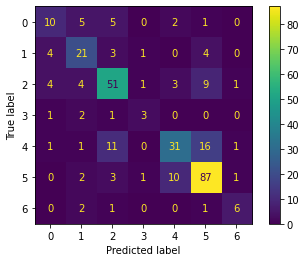

In [ ]:
model_ = Model_Grid.model.eval()
X = input_data[2].to(device)
Y = labels[2].to(device)
Y_pred = model_(X).argmax(dim=1)
confusion_matrix(Y.to('cpu'),Y_pred.to('cpu'))

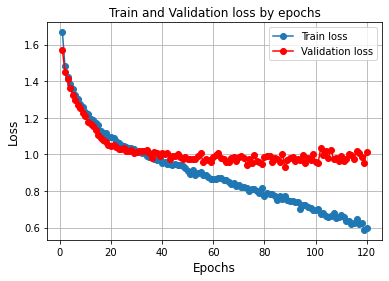

In [ ]:
model_ = Model_Grid
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))
plt.plot(epochs_X , model_.Epochs_Train_loss, 'o-', label='Train loss')
plt.plot(epochs_X , model_.Epochs_Val_loss,'ro-', label='Validation loss')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation loss by epochs')
plt.show()

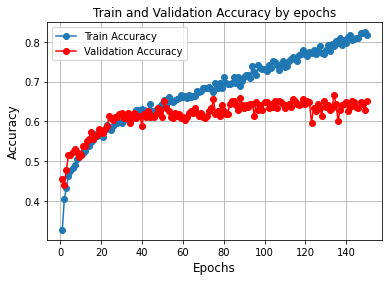

In [ ]:
model_ = Model_Grid
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_Acc, 'o-', label='Train Accuracy')
plt.plot(epochs_X , model_.Epochs_Val_Acc,'ro-', label='Validation Accuracy')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation Accuracy by epochs')
plt.show()

# **Model by best hyper params with valid and test set**

In [27]:
print_epochs = True

param1 = {'LR': 1e-4,
 'Momentum': 0.6,
 'Net': Net3,
 'batch_size': 64,
 'epochs': 50,
 'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
 'opt_func': torch.optim.SGD,
 'weight_decay': 0}

# with data loader
Model_Best_Grid = Model_Training_with_loader(**param1,w_sampler = w_sampler , trainDataset = trainDataset, validDataset = validDataset , X_test = X_test, Y_test = Y_test, print_epochs =print_epochs,hyper_params=param1)
# without data loader
# Model_Best_Grid = Model_Training(**param1, X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid, X_test = X_test, Y_test= Y_test, print_epochs = print_epochs,hyper_params=param1,Test_acc_print=Test_acc_print)
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
Model_Best_Grid.train()

[Epoch: 1]  , Train_loss: 1.9 , Train_Acc: 14.0%, Val_loss: 2.0 , Val_Acc: 12.5%, Test_Acc: 12.0%  , run time: 5.17
[Epoch: 2]  , Train_loss: 1.9 , Train_Acc: 17.3%, Val_loss: 2.0 , Val_Acc: 13.4%, Test_Acc: 14.2%  , run time: 5.2
[Epoch: 3]  , Train_loss: 1.9 , Train_Acc: 17.7%, Val_loss: 2.0 , Val_Acc: 15.5%, Test_Acc: 14.6%  , run time: 5.04
[Epoch: 4]  , Train_loss: 1.9 , Train_Acc: 18.2%, Val_loss: 2.0 , Val_Acc: 16.0%, Test_Acc: 15.8%  , run time: 5.07
[Epoch: 5]  , Train_loss: 1.9 , Train_Acc: 19.5%, Val_loss: 1.9 , Val_Acc: 16.8%, Test_Acc: 16.0%  , run time: 5.04
[Epoch: 6]  , Train_loss: 1.9 , Train_Acc: 19.9%, Val_loss: 2.0 , Val_Acc: 16.7%, Test_Acc: 15.5%  , run time: 5.03
[Epoch: 7]  , Train_loss: 1.9 , Train_Acc: 21.6%, Val_loss: 1.9 , Val_Acc: 18.1%, Test_Acc: 17.0%  , run time: 5.05
[Epoch: 8]  , Train_loss: 1.9 , Train_Acc: 22.9%, Val_loss: 1.9 , Val_Acc: 18.9%, Test_Acc: 18.8%  , run time: 4.98
[Epoch: 9]  , Train_loss: 1.9 , Train_Acc: 23.0%, Val_loss: 1.9 , Val_Acc

In [18]:
import torch
torch.cuda.empty_cache()


Nr. of Data : 
 554
Accuracy of The Model : 
 0.5956678700361011


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,8.3%,48.1%,54.3%,94.7%,51.0%
1,11.7%,60.0%,46.2%,95.9%,52.2%
2,13.2%,43.4%,31.5%,93.8%,36.5%
3,2.7%,33.3%,33.3%,98.1%,33.3%
4,11.0%,33.8%,72.1%,82.6%,46.1%
5,49.5%,86.5%,72.6%,88.9%,79.0%
6,3.6%,16.7%,20.0%,96.3%,18.2%
Simple Avg.,nan%,46.0%,47.2%,92.9%,45.2%
Weighted Avg.,nan%,64.8%,59.6%,90.7%,60.9%


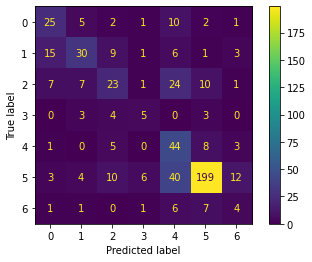

In [24]:
model_1 = Model_Best_Grid.model.eval()
X = input_data[2].to(device)
Y = labels[2].to(device)
Y_pred = model_1(X).argmax(dim=1)
confusion_matrix(Y.to('cpu'),Y_pred.to('cpu'))

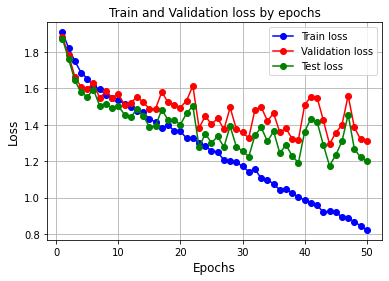

In [25]:
model_ = Model_Best_Grid
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_loss, 'bo-', label='Train loss')
plt.plot(epochs_X , model_.Epochs_Val_loss,'ro-', label='Validation loss')
plt.plot(epochs_X , model_.Epochs_test_loss,'go-', label='Test loss')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation loss by epochs')
plt.show()

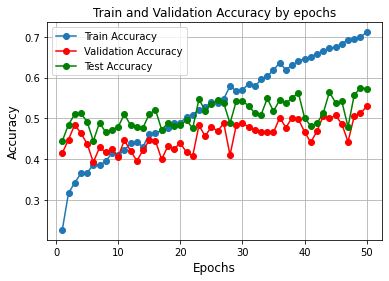

In [26]:
model_ = Model_Best_Grid
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_Acc, 'o-', label='Train Accuracy')
plt.plot(epochs_X , model_.Epochs_Val_Acc,'ro-', label='Validation Accuracy')
plt.plot(epochs_X , model_.Epochs_test_Acc,'go-', label='Test Accuracy')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation Accuracy by epochs')
plt.show()

# **K-Fold Cross Validation**

In [ ]:
K_Folds = sk.model_selection.KFold(n_splits=6, shuffle=True)
tensor_subset = torch.utils.data.dataset.Subset

print_epochs = False
# device = 'mps'

CV_data = input_data[3]
CV_label = labels[3]
X_test = input_data[2]
Y_test = labels[2]

# CV_Details_ = pd.DataFrame(columns=['test_fscore','test_precision','test_recall'])

CV_Details = pd.DataFrame(columns=['hyper_param','train_index','valid_index','train_accuracy','valid_accuracy','test_accuracy','train_fscore','valid_fscore','test_fscore','train_precision','valid_precision','test_precision'
                                    ,'train_recall','valid_recall','test_recall'])

pbar = tqdm(best_params, ncols = 100, desc = "Hyper Parameters - Level")

for param in pbar:
# for i in range(1):
    
    for fold, (train_index, valid_index) in enumerate(K_Folds.split(CV_data)):


        X_train = CV_data[train_index]
        Y_train = CV_label[train_index]
        X_valid = CV_data[valid_index]
        Y_valid = CV_label[valid_index]

        # X_train = tensor_subset(input_data[3],train_index).dataset
        # Y_train = tensor_subset(labels[3],train_index).dataset
        # X_valid = tensor_subset(input_data[3],valid_index).dataset
        # Y_valid = tensor_subset(labels[3],valid_index).dataset

        Model_ = Model_Training(**param, X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid, print_epochs = print_epochs,hyper_params=param)
        np.random.seed(0)
        random.seed(0)
        torch.manual_seed(0)
        Model_.train()

        model_ = Model_.model.eval()
            
        # Train
        Y_pred = model_(X_train.to(device)).argmax(axis=1)
        Y = Y_train
        train_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        train_precision, train_recall, train_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')

        # Valid
        Y_pred = model_(X_valid.to(device)).argmax(axis=1)
        Y = Y_valid
        valid_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        valid_precision, valid_recall, valid_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')

        # Test
        Y_pred = model_(X_test.to(device)).argmax(axis=1)
        Y = Y_test
        test_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        test_precision, test_recall, test_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')
        pbar.set_description("Test Accuracy %s" % test_accuracy)
        
        new_row = pd.Series({'hyper_param':param,'train_index':train_index,'valid_index':valid_index,'train_accuracy':train_accuracy,'valid_accuracy':valid_accuracy,'test_accuracy':test_accuracy,'train_fscore':train_fscore,'valid_fscore':valid_fscore,'test_fscore':test_fscore
        ,'train_precision':train_precision,'valid_precision':valid_precision,'test_precision':test_precision,'train_recall':train_recall,'valid_recall':valid_recall,'test_recall':test_recall}, name='')
        CV_Details = CV_Details.append(new_row)

CNN_CV_Details = CV_Details.sort_values('test_accuracy', ascending=False)

Test Accuracy 0.6237942122186495: 100%|██████████████████████████████| 4/4 [10:00<00:00, 150.14s/it]


In [ ]:
CNN_CV_Details['test_accuracy'][:5], CNN_CV_Details['hyper_param'][0]

(    0.662379
     0.655949
     0.649518
     0.649518
     0.649518
 Name: test_accuracy, dtype: float64,
 {'LR': 0.0018,
  'Momentum': 0.85,
  'Net': __main__.CNN_Net4,
  'batch_size': 32,
  'epochs': 80,
  'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
  'opt_func': torch.optim.sgd.SGD,
  'weight_decay': 1e-06})

In [ ]:
CNN_CV_Details['test_accuracy'][:5], CNN_CV_Details['hyper_param'][0]

(    0.652733
     0.649518
     0.646302
     0.643087
     0.643087
 Name: test_accuracy, dtype: float64,
 {'LR': 0.0022,
  'Momentum': 0.82,
  'Net': __main__.CNN_Net3,
  'batch_size': 30,
  'epochs': 75,
  'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
  'opt_func': torch.optim.sgd.SGD,
  'weight_decay': 1e-07})

In [29]:
import torch
torch.cuda.empty_cache()

In [28]:
print_epochs = True
# param = CNN_CV_Details['hyper_param'][0]
# train_index = CNN_CV_Details['train_index'][0]
# valid_index = CNN_CV_Details['valid_index'][0]

# X_train = input_data[3][train_index]
# Y_train = labels[3][train_index]
# X_valid = input_data[3][valid_index]
# Y_valid = labels[3][valid_index]

X_train = input_data[0]
Y_train = labels[0]
X_valid = input_data[1]
Y_valid = labels[1]


param1 = {'LR': 1e-3,
 'Momentum': 0.8,
 'Net': CNN_Nets.Net3,
 'batch_size': 32,
 'epochs': 10,
 'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
 'opt_func': torch.optim.SGD,
 'weight_decay': 0}

Model_CV = Model_Training(**param1,X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid, print_epochs =print_epochs,hyper_params=param1)
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
Model_CV.train()

RuntimeError: ignored

Nr. of Data : 
 820
Accuracy of The Model : 
 0.6560975609756098


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.6%,14.3%,4.3%,98.4%,6.7%
1,7.9%,33.3%,12.3%,97.9%,18.0%
2,8.9%,35.7%,13.7%,97.6%,19.8%
3,1.8%,0.0%,0.0%,99.9%,0.0%
4,7.4%,6.2%,1.6%,98.0%,2.6%
5,65.9%,70.1%,95.7%,21.4%,81.0%
6,2.4%,0.0%,0.0%,100.0%,0.0%
Simple Avg.,nan%,22.8%,18.2%,87.6%,18.3%
Weighted Avg.,nan%,53.3%,65.6%,47.6%,57.1%


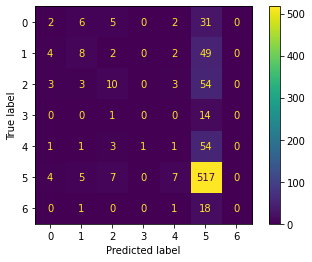

In [20]:
model_ = Model_CV.model.eval()
X = input_data[2].to(device)
Y = labels[2].to(device)
Y_pred = model_(X).argmax(dim=1)
confusion_matrix(Y.to('cpu'),Y_pred.to('cpu'))

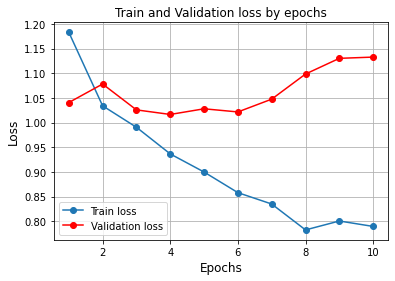

In [21]:
model_ = Model_CV
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_loss, 'o-', label='Train loss')
plt.plot(epochs_X , model_.Epochs_Val_loss,'ro-', label='Validation loss')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation loss by epochs')
plt.show()

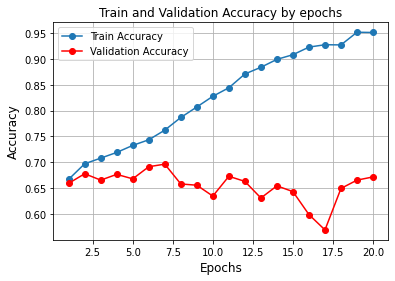

In [17]:
model_ = Model_CV
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_Acc, 'o-', label='Train Accuracy')
plt.plot(epochs_X , model_.Epochs_Val_Acc,'ro-', label='Validation Accuracy')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation Accuracy by epochs')
plt.show()

# **100 time model training to check Regularization of hyper parameters by Cross Validation**

In [ ]:
K_Folds_test = sk.model_selection.KFold(n_splits=10, shuffle=True)
K_Folds_valid = sk.model_selection.KFold(n_splits=10, shuffle=True)

param1 = {'LR': 2e-3,
 'Momentum': 0.78,
 'Net': CNN_Nets.Net3,
 'batch_size': 30,
 'epochs': 100,
 'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
 'opt_func': torch.optim.SGD,
 'weight_decay': 1e-06}


print_epochs = False
# device = 'mps'

CV_data = input_data[4]
CV_label = labels[4]
# CV_Details_ = pd.DataFrame(columns=['test_fscore','test_precision','test_recall'])

CV_Details = pd.DataFrame(columns=['hyper_param','train_index','valid_index','train_accuracy','valid_accuracy','test_accuracy','train_fscore','valid_fscore','test_fscore','train_precision','valid_precision','test_precision'
                                    ,'train_recall','valid_recall','test_recall'])

# pbar = tqdm(range(10), ncols = 100, desc = "Hyper Parameters - Level")
pbar = tqdm(enumerate(K_Folds_test.split(CV_data)), total=K_Folds_test.get_n_splits(), desc="Test set k-fold",ncols = 100)

for fold, (training_index, test_index) in pbar:
    X_training = CV_data[training_index]
    Y_training = CV_label[training_index]
    X_test = CV_data[test_index]
    Y_test = CV_label[test_index]

    for fold, (train_index, valid_index) in enumerate(K_Folds_valid.split(X_training)):
        X_train = X_training[train_index]
        Y_train = Y_training[train_index]
        X_valid = X_training[valid_index]
        Y_valid = Y_training[valid_index]

        # X_train = tensor_subset(input_data[3],train_index).dataset
        # Y_train = tensor_subset(labels[3],train_index).dataset
        # X_valid = tensor_subset(input_data[3],valid_index).dataset
        # Y_valid = tensor_subset(labels[3],valid_index).dataset

        Model_ = Model_Training(**param1, X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid, print_epochs = print_epochs,hyper_params=param)
        np.random.seed(0)
        random.seed(0)
        torch.manual_seed(0)
        Model_.train()

        model_ = Model_.model.eval()
            
        # Train
        Y_pred = model_(X_train.to(device)).argmax(axis=1)
        Y = Y_train
        train_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        train_precision, train_recall, train_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')

        # Valid
        Y_pred = model_(X_valid.to(device)).argmax(axis=1)
        Y = Y_valid
        valid_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        valid_precision, valid_recall, valid_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')

        # Test
        Y_pred = model_(X_test.to(device)).argmax(axis=1)
        Y = Y_test
        test_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        test_precision, test_recall, test_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')
        pbar.set_description("Test Accuracy %s" % test_accuracy)
        
        new_row = pd.Series({'hyper_param':param,'train_index':train_index,'valid_index':valid_index,'train_accuracy':train_accuracy,'valid_accuracy':valid_accuracy,'test_accuracy':test_accuracy,'train_fscore':train_fscore,'valid_fscore':valid_fscore,'test_fscore':test_fscore
        ,'train_precision':train_precision,'valid_precision':valid_precision,'test_precision':test_precision,'train_recall':train_recall,'valid_recall':valid_recall,'test_recall':test_recall}, name='')
        CV_Details = CV_Details.append(new_row)

CV_Regularization_Details = CV_Details.sort_values('test_accuracy', ascending=False)
dat_hour = datetime.now().strftime("%d_%b_%Y_%H:%M")
CV_Regularization_Details.to_csv(G_save + 'CV_Regularization_Details_'+ dat_hour+ '.csv')

Test Accuracy 0.6516129032258065: 100%|████████████████████████████| 10/10 [38:54<00:00, 233.49s/it]


In [ ]:
import time
import tqdm

for outer in tqdm.tqdm_notebook(range(5), ncols = 1000, desc = "First CV", position = 0, leave=True):
    for inner in tqdm.tqdm_notebook(range(3), ncols = 1000, desc = "Second CV", position = 1, leave=True):
        time.sleep(0.5)
print("done!")

First CV:   0%|                                                                                               …

Second CV:   0%|                                                                                              …

Second CV:   0%|                                                                                              …

Second CV:   0%|                                                                                              …

Second CV:   0%|                                                                                              …

Second CV:   0%|                                                                                              …

done!


In [ ]:
test_models

,test_accuracy,test_precision,test_fscore
,0.674194,0.706111,0.687295
,0.665595,0.700969,0.673947
,0.662379,0.695334,0.671039
,0.659164,0.682044,0.664517
,0.655949,0.679155,0.662436
...,...,...,...
,0.572347,0.585488,0.573593
,0.572347,0.584676,0.574928
,0.569132,0.584228,0.569890
,0.569132,0.587287,0.567741


In [ ]:
col_test = ['test_accuracy','test_precision','test_fscore']
test_models = CV_Regularization_Details[col_test]
col_valid = ['valid_accuracy','valid_precision','valid_fscore']
valid_models = CV_Regularization_Details[col_valid]
train_test = ['train_accuracy','train_precision','train_fscore']
train_models = CV_Regularization_Details[train_test]

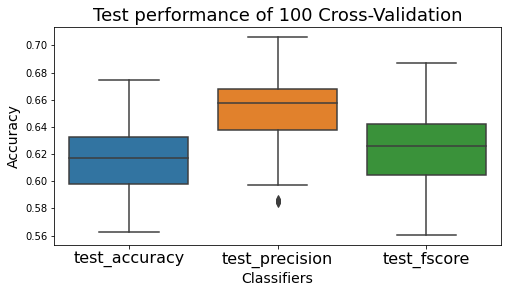

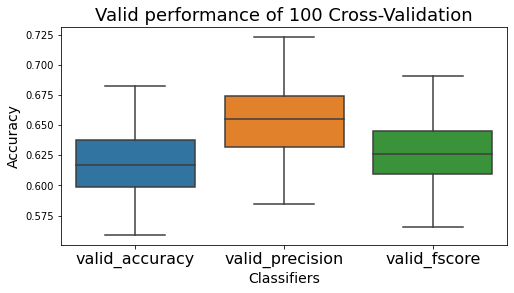

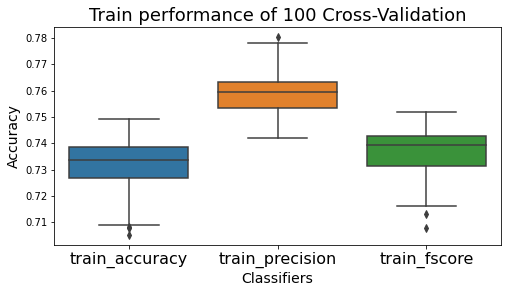

In [ ]:
plt.subplots(figsize=(8,4))
sns.boxplot(data=test_models)
plt.title('Test performance of 100 Cross-Validation',fontsize = 18)
plt.xlabel("Classifiers", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

plt.subplots(figsize=(8,4))
sns.boxplot(data=valid_models)
plt.title('Valid performance of 100 Cross-Validation',fontsize = 18)
plt.xlabel("Classifiers", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

plt.subplots(figsize=(8,4))
sns.boxplot(data=train_models)
plt.title('Train performance of 100 Cross-Validation',fontsize = 18)
plt.xlabel("Classifiers", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

# **Save the model**

In [ ]:
dat_hour = datetime.now().strftime("%d_%b_%Y_%H:%M")
pickle.dump(Model_Grid, open(G_save + 'CNN_60x45_Best_Grid_'+dat_hour, 'wb'))
pickle.dump(Model_CV, open(G_save + 'CNN_60x45_Best_CV_'+dat_hour, 'wb'))

# **Save Grid search-Cross Validation Details**

In [ ]:
pickle.dump([CNN_Nets, Model_Training], open(G_save + 'CNNs_Network_Training', "wb"))

In [ ]:
dat_hour = datetime.now().strftime("%d_%b_%Y_%H:%M")
pickle.dump(Grid_Details, open(G_save + 'Grid_Details_'+dat_hour, 'wb'))
pickle.dump(CNN_CV_Details, open(G_save + 'CNN_CV_Details_'+dat_hour, 'wb'))

Grid_Details.to_csv(G_save + 'Grid_Details_'+dat_hour +'.csv')
CNN_CV_Details.to_csv(G_save + 'CNN_CV_Details_'+dat_hour+ '.csv')